In [70]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [71]:
jokes_all = pd.read_csv('../data/jokes.csv')
jokes_all['dad'] = jokes_all['subreddit'].map(lambda x: 1 if x == 'dadjokes' else 0)

In [72]:
p_stemmer = PorterStemmer()
def porter(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = p_stemmer.stem(text_l[i])
    return ' '.join(text_l)

jokes_all['porter'] = jokes_all['full_text'].map(porter)
jokes_all[['full_text','porter']].head()

,full_text,porter
0,Anybody know that show Naked and Afraid? That'...,anybodi know that show nake and afraid? that' ...
1,You don't need a therapist.... A 5 year old wi...,you don't need a therapist.... a 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,whi are fizzi drink so tasty? they are soda-lici
3,I tried drag racing the other day It's brutal ...,i tri drag race the other day it' brutal run i...
4,"In the next season of Ozark, Marty becomes the...","in the next season of ozark, marti becom the m..."


In [73]:
lemmatizer = WordNetLemmatizer()
def lemonize(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = lemmatizer.lemmatize(text_l[i])
    return ' '.join(text_l)

jokes_all['lemon'] = jokes_all['full_text'].map(lemonize)
jokes_all[['full_text','lemon']].head()

,full_text,lemon
0,Anybody know that show Naked and Afraid? That'...,Anybody know that show Naked and Afraid? That'...
1,You don't need a therapist.... A 5 year old wi...,You don't need a therapist.... A 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,Why are fizzy drink so tasty? They are soda-li...
3,I tried drag racing the other day It's brutal ...,I tried drag racing the other day It's brutal ...
4,"In the next season of Ozark, Marty becomes the...","In the next season of Ozark, Marty becomes the..."


In [74]:
jokes_all[jokes_all['full_text'].str.contains('pink')]['subreddit'].value_counts()

AntiJokes    14
dadjokes      3
Name: subreddit, dtype: int64

In [75]:
jokes_all['ft_length'] = jokes_all['full_text'].map(lambda x: len(x))
jokes_all['ft_wc'] = jokes_all['full_text'].map(lambda x: len(x.split()))

sent = SentimentIntensityAnalyzer()
jokes_all['sent_compound'] = [sent.polarity_scores(x)['compound'] for x in jokes_all['full_text']]
jokes_all['sent_neg'] = [sent.polarity_scores(x)['neg'] for x in jokes_all['full_text']]
jokes_all['sent_neu'] = [sent.polarity_scores(x)['neu'] for x in jokes_all['full_text']]
jokes_all['sent_pos'] = [sent.polarity_scores(x)['pos'] for x in jokes_all['full_text']]

jokes_all.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,full_text,dad,porter,lemon,ft_length,ft_wc,sent_compound,sent_neg,sent_neu,sent_pos
0,0,Anybody know that show Naked and Afraid?,That's what I call hide and seek with my uncle...,dadjokes,1627664369,Moose908H,3,1,True,Anybody know that show Naked and Afraid? That'...,1,anybodi know that show nake and afraid? that' ...,Anybody know that show Naked and Afraid? That'...,91,18,-0.1779,0.096,0.904,0.0
1,1,You don't need a therapist....,A 5 year old will tell you everything that's w...,dadjokes,1627664264,VERBERD,2,1,True,You don't need a therapist.... A 5 year old wi...,1,you don't need a therapist.... a 5 year old wi...,You don't need a therapist.... A 5 year old wi...,104,19,-0.4767,0.171,0.829,0.0
2,2,Why are fizzy drinks so tasty?,They are soda-licious,dadjokes,1627664007,techtornado,3,1,True,Why are fizzy drinks so tasty? They are soda-l...,1,whi are fizzi drink so tasty? they are soda-lici,Why are fizzy drink so tasty? They are soda-li...,52,9,0.0000,0.000,1.000,0.0
3,3,I tried drag racing the other day,It's brutal running in those heels!,dadjokes,1627662305,Moose908H,1,1,True,I tried drag racing the other day It's brutal ...,1,i tri drag race the other day it' brutal run i...,I tried drag racing the other day It's brutal ...,69,13,-0.7424,0.386,0.614,0.0
4,4,"In the next season of Ozark, Marty becomes the...",Byrde is the Word,dadjokes,1627661919,DinglebarryHandpump,0,1,True,"In the next season of Ozark, Marty becomes the...",1,"in the next season of ozark, marti becom the m...","In the next season of Ozark, Marty becomes the...",72,14,0.0000,0.000,1.000,0.0


In [76]:
english_stop = list(stopwords.words('english'))
def after_isare(x):
    count = 0
    word_list = x.title.split()
    for i in range(len(word_list)-1):
        if 'is' == word_list[i] or 'are' == word_list[i]:
            if word_list[i+1] not in english_stop:
                count += x.selftext.count(word_list[i+1])
    return count

jokes_all['after_isare'] = jokes_all[['title','selftext']].apply(after_isare,axis=1)
jokes_all[jokes_all['after_isare'] > 0]['title']

16                                  Education is important
27                                          Life is though
401                                        My crow is soft
783      Waht is ta the the Sir Isaac Newton’s favouirt...
844      When your wife is angry with you, bring a towe...
                               ...                        
11390    An orphan is waiting by the school gates when ...
11456              the real joke is always in the comments
11648    [One month after the all the family members ha...
11734    If sex with three people is called a Three-som...
11835    A man is reposting at a bar when he tries stan...
Name: title, Length: 67, dtype: object

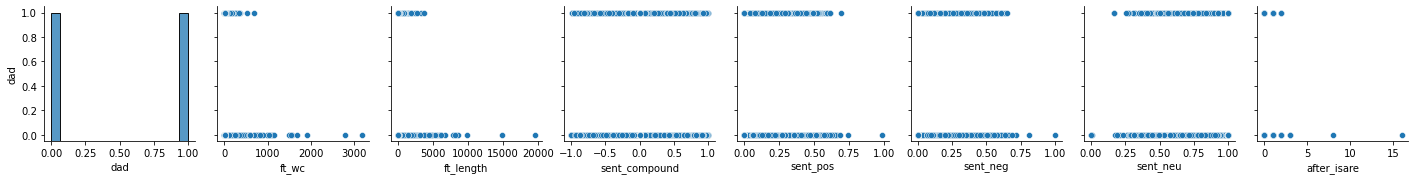

In [77]:
sns.pairplot(jokes_all[['dad','ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu','after_isare']],y_vars = ['dad'])


In [78]:
stop_dad = ['dad','son','daughter','son','anti','antijokes','antijoke']

In [79]:
X = jokes_all['full_text']
y = jokes_all['dad']
X_dj = jokes_all[jokes_all['dad'] == 1]['full_text']
y_dj = jokes_all[jokes_all['dad'] == 1]['dad']
X_aj = jokes_all[jokes_all['dad'] == 0]['full_text']
y_aj = jokes_all[jokes_all['dad'] == 0]['dad']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [80]:
gs_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])
gs_params = {'cvec__min_df': [2],
 'cvec__ngram_range': [(1, 6)],
 'cvec__stop_words': [stop_dad]
    }


gstf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB() )
])
gstf_params = {'tvec__min_df': [2],
 'tvec__ngram_range': [(1, 2)],
 'tvec__stop_words': [stop_dad]
              }

gslr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])
gslr_params = {
    'lr__max_iter': [100000],
 'lr__penalty': ['none'],
 'lr__solver': ['sag'],
 'tvec__min_df': [1],
 'tvec__ngram_range': [(1, 3)],
 'tvec__stop_words': [stop_dad]
}

gsdt_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=42))
])
gsdt_params = {'dt__max_depth': [45],
 'dt__min_samples_leaf': [1],
 'dt__min_samples_split': [5],
 'tvec__min_df': [3],
 'tvec__ngram_range': [(1, 6)],
 'tvec__stop_words': [stop_dad]}

gsrf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

gsrf_params={'rf__max_depth': [30],
 'rf__max_features': ['auto'],
 'rf__min_samples_leaf': [2],
 'rf__min_samples_split': [5],
 'rf__n_estimators': [400],
 'tvec__min_df':[4],
 'tvec__ngram_range': [(1, 6)],
 'tvec__stop_words': [stop_dad]}



In [81]:
Xlem = jokes_all['lemon']
ylem = jokes_all['dad']
Xlem_dj = jokes_all[jokes_all['dad'] == 1]['lemon']
ylem_dj = jokes_all[jokes_all['dad'] == 1]['dad']
Xlem_aj = jokes_all[jokes_all['dad'] == 0]['lemon']
ylem_aj = jokes_all[jokes_all['dad'] == 0]['dad']
Xlem_train, Xlem_test, ylem_train, ylem_test = train_test_split(Xlem,ylem,test_size=0.2,random_state=42)
cvec_lemaj = CountVectorizer(stop_words='english')
Xcv_lemaj = cvec_lemaj.fit_transform(Xlem_aj,ylem_aj)
Xcv_lemajdf = pd.DataFrame(Xcv_lemaj.todense(),columns=cvec_lemaj.get_feature_names())
Xcv_lemajdf.head()

cvec_lemdj = CountVectorizer(stop_words='english')
Xcv_lemdj = cvec_lemdj.fit_transform(Xlem_dj,ylem_dj)
Xcv_lemdjdf = pd.DataFrame(Xcv_lemdj.todense(),columns=cvec_lemdj.get_feature_names())
Xcv_lemdjdf.head()


,00,000,01k,02,05,07,0mg,0nsznmdxnzu,10,100,...,𝒊𝒏,𝒍𝒊𝒌𝒆𝒏𝒆𝒅,𝒑𝒉𝒂𝒓𝒂𝒐𝒉,𝒕𝒉𝒆,𝒕𝒐,𝒚𝒐𝒖𝒏𝒈𝒆𝒔𝒕,𝙏𝙤𝙤𝙩,𝙖𝙣,𝙘𝙤𝙢𝙢𝙤𝙣,𝙞𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
Xport = jokes_all['porter']
yport = jokes_all['dad']
Xport_dj = jokes_all[jokes_all['dad'] == 1]['porter']
yport_dj = jokes_all[jokes_all['dad'] == 1]['dad']
Xport_aj = jokes_all[jokes_all['dad'] == 0]['porter']
yport_aj = jokes_all[jokes_all['dad'] == 0]['dad']
Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)

cvec_portaj = CountVectorizer(stop_words='english')
Xcv_portaj = cvec_portaj.fit_transform(Xport_aj,yport_aj)
Xcv_portajdf = pd.DataFrame(Xcv_portaj.todense(),columns=cvec_portaj.get_feature_names())

cvec_portdj = CountVectorizer(stop_words='english')
Xcv_portdj = cvec_portdj.fit_transform(Xport_dj,yport_dj)
Xcv_portdjdf = pd.DataFrame(Xcv_portdj.todense(),columns=cvec_portdj.get_feature_names())
Xcv_portdjdf.head()


,00,000,01k,02,05,07,0mg,0nsznmdxnzu,10,100,...,𝒊𝒏,𝒍𝒊𝒌𝒆𝒏𝒆𝒅,𝒑𝒉𝒂𝒓𝒂𝒐𝒉,𝒕𝒉𝒆,𝒕𝒐,𝒚𝒐𝒖𝒏𝒈𝒆𝒔𝒕,𝙏𝙤𝙤𝙩,𝙖𝙣,𝙘𝙤𝙢𝙢𝙤𝙣,𝙞𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
def plot_cfm(fit,xtrain,ytrain,xtest,ytest):
    print(fit.score(xtrain,ytrain),fit.score(xtest,ytest))
    preds = fit.predict(xtest)

    tn, fp, fn, tp = confusion_matrix(ytest, preds).ravel()
    plot_confusion_matrix(fit, xtest, ytest, cmap='Blues');
    return fit.score(xtrain,ytrain),fit.score(xtest,ytest)

0.876926259178819 0.707196029776675


(0.876926259178819, 0.707196029776675)

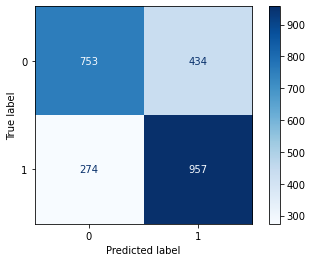

In [84]:
gs = GridSearchCV(gs_pipe,gs_params,cv =5)
gs.fit(X_train,y_train)
plot_cfm(gs,X_train,y_train,X_test,y_test)

0.9053676698727893 0.7303556658395368


(0.9053676698727893, 0.7303556658395368)

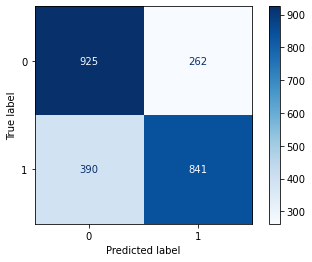

In [85]:
gstf = GridSearchCV(gstf_pipe,gstf_params,cv =5)
gstf.fit(X_train,y_train)
plot_cfm(gstf,X_train,y_train,X_test,y_test)

0.9989657668838556 0.7440033085194375


(0.9989657668838556, 0.7440033085194375)

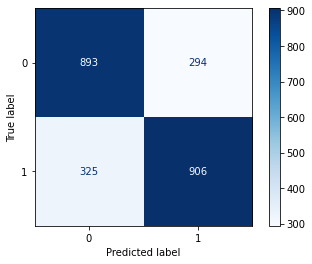

In [86]:
gslr = GridSearchCV(gslr_pipe,gslr_params,cv =5)
gslr.fit(X_train,y_train)
plot_cfm(gslr,X_train,y_train,X_test,y_test)

0.8874754369634916 0.6451612903225806


(0.8874754369634916, 0.6451612903225806)

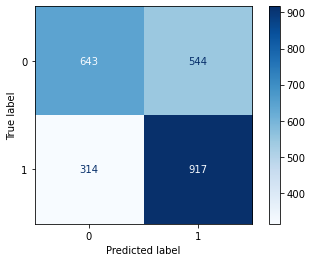

In [87]:
gsdt = GridSearchCV(gsdt_pipe,gsdt_params,cv =5)
gsdt.fit(X_train,y_train)
plot_cfm(gsdt,X_train,y_train,X_test,y_test)

0.7875685179439446 0.7138130686517783


(0.7875685179439446, 0.7138130686517783)

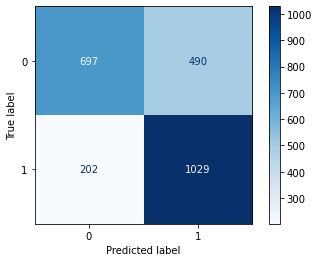

In [88]:
gsrf = GridSearchCV(gsrf_pipe,gsrf_params,cv =5)
gsrf.fit(X_train,y_train)
plot_cfm(gsrf,X_train,y_train,X_test,y_test)

0.879304995345951 0.7133995037220844


(0.879304995345951, 0.7133995037220844)

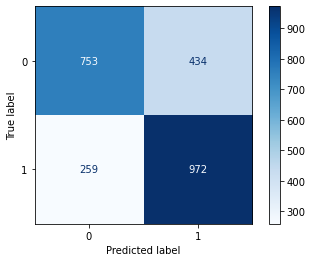

In [89]:
gs_lem = GridSearchCV(gs_pipe,gs_params,cv =5)
gs_lem.fit(Xlem_train,ylem_train)
plot_cfm(gs_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)

0.9048505533147171 0.7224979321753515


(0.9048505533147171, 0.7224979321753515)

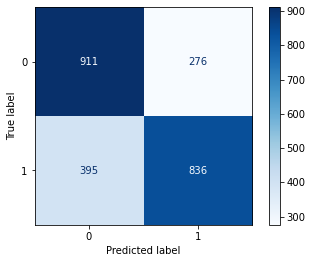

In [90]:
gstf_lem = GridSearchCV(gstf_pipe,gstf_params,cv =5)
gstf_lem.fit(Xlem_train,ylem_train)
plot_cfm(gstf_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)

0.99906919019547 0.7411083540115798


(0.99906919019547, 0.7411083540115798)

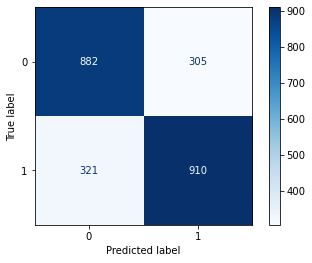

In [91]:
gslr_lem = GridSearchCV(gslr_pipe,gslr_params,cv =5)
gslr_lem.fit(Xlem_train,ylem_train)
plot_cfm(gslr_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)

0.8914055228048402 0.6513647642679901


(0.8914055228048402, 0.6513647642679901)

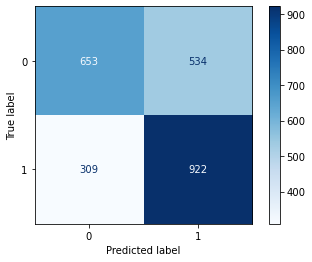

In [92]:
gsdt_lem = GridSearchCV(gsdt_pipe,gsdt_params,cv =5)
gsdt_lem.fit(Xlem_train,ylem_train)
plot_cfm(gsdt_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)

0.7895335608646189 0.705955334987593


(0.7895335608646189, 0.705955334987593)

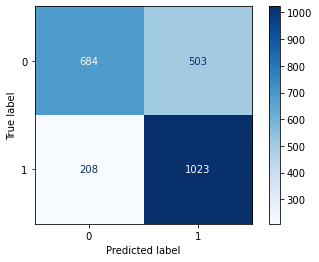

In [93]:
gsrf_lem = GridSearchCV(gsrf_pipe,gsrf_params,cv =5)
gsrf_lem.fit(Xlem_train,ylem_train)
plot_cfm(gsrf_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)

0.8743406763884579 0.7043010752688172


(0.8743406763884579, 0.7043010752688172)

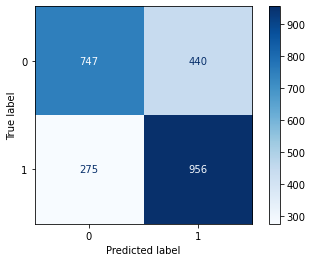

In [94]:
gs_port = GridSearchCV(gs_pipe,gs_params,cv =5)
gs_port.fit(Xport_train,yport_train)
plot_cfm(gs_port,Xport_train,yport_train,Xport_test,yport_test)

0.9052642465611749 0.7241521918941274


(0.9052642465611749, 0.7241521918941274)

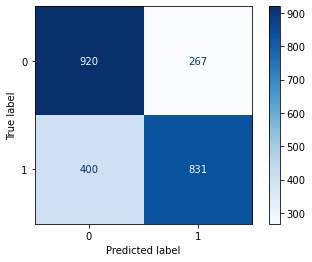

In [95]:
gstf_port = GridSearchCV(gstf_pipe,gstf_params,cv =5)
gstf_port.fit(Xport_train,yport_train)
plot_cfm(gstf_port,Xport_train,yport_train,Xport_test,yport_test)

0.99906919019547 0.73904052936311


(0.99906919019547, 0.73904052936311)

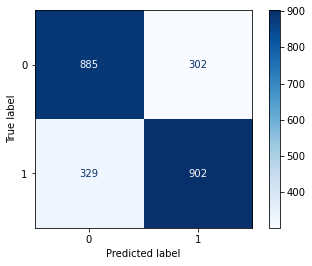

In [96]:
gslr_port = GridSearchCV(gslr_pipe,gslr_params,cv =5)
gslr_port.fit(Xport_train,yport_train)
plot_cfm(gslr_port,Xport_train,yport_train,Xport_test,yport_test)

0.886648050470576 0.6488833746898263


(0.886648050470576, 0.6488833746898263)

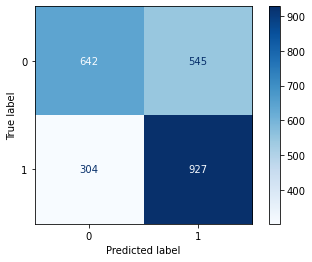

In [97]:
gsdt_port = GridSearchCV(gsdt_pipe,gsdt_params,cv =5)
gsdt_port.fit(Xport_train,yport_train)
plot_cfm(gsdt_port,Xport_train,yport_train,Xport_test,yport_test)

0.7873616713207157 0.7158808933002482


(0.7873616713207157, 0.7158808933002482)

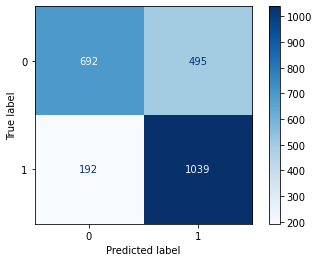

In [98]:
gsrf_port = GridSearchCV(gsrf_pipe,gsrf_params,cv =5)
gsrf_port.fit(Xport_train,yport_train)
plot_cfm(gsrf_port,Xport_train,yport_train,Xport_test,yport_test)

In [99]:
Xport = jokes_all[['porter','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
yport = jokes_all['dad']

Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)

In [100]:
cv_port = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
Xport_train_cv = cv_port.fit_transform(Xport_train['porter'])

Xport_train_df = pd.DataFrame(Xport_train_cv.todense(),
                              columns=cv_port.get_feature_names()).reset_index()

Xport_train_sent = Xport_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()

Xport_train_df = pd.concat([Xport_train_df,Xport_train_sent],axis = 1)

In [101]:
Xport_test_cv = cv_port.transform(Xport_test['porter'])
Xport_test_df = pd.DataFrame(Xport_test_cv.todense(),
                             columns=cv_port.get_feature_names()).reset_index()

Xport_test_sent = Xport_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()

Xport_test_df = pd.concat([Xport_test_df,Xport_test_sent],axis = 1)
print(Xport_train_df.shape,Xport_test_df.shape)

(9669, 15203) (2418, 15203)


In [102]:
Xport_train_df.drop(columns='index',inplace=True)
Xport_test_df.drop(columns='index',inplace=True)

In [103]:
ss = StandardScaler(with_mean=False)

Ztrain = ss.fit_transform(Xport_train_df,yport_train)
Ztest = ss.transform(Xport_test_df)
print(Ztrain.shape,Ztest.shape)
lr = LogisticRegressionCV(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-5,0,41), cv = 5)
lr.fit(Ztrain,yport_train)

(9669, 15201) (2418, 15201)


LogisticRegressionCV(Cs=array([1.00000000e-05, 1.33352143e-05, 1.77827941e-05, 2.37137371e-05,
       3.16227766e-05, 4.21696503e-05, 5.62341325e-05, 7.49894209e-05,
       1.00000000e-04, 1.33352143e-04, 1.77827941e-04, 2.37137371e-04,
       3.16227766e-04, 4.21696503e-04, 5.62341325e-04, 7.49894209e-04,
       1.00000000e-03, 1.33352143e-03, 1.77827941e-03, 2.37137371e-03,
       3.16227766e-03, 4.21...1325e-03, 7.49894209e-03,
       1.00000000e-02, 1.33352143e-02, 1.77827941e-02, 2.37137371e-02,
       3.16227766e-02, 4.21696503e-02, 5.62341325e-02, 7.49894209e-02,
       1.00000000e-01, 1.33352143e-01, 1.77827941e-01, 2.37137371e-01,
       3.16227766e-01, 4.21696503e-01, 5.62341325e-01, 7.49894209e-01,
       1.00000000e+00]),
                     cv=5, max_iter=100000, penalty='l1', random_state=42,
                     solver='liblinear')

In [104]:
lr.score(Ztrain, yport_train), lr.score(Ztest, yport_test),lr.C_

(0.8647223084083152, 0.717535153019024, array([0.01778279]))

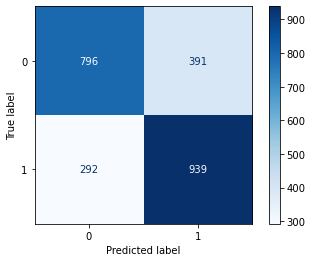

In [105]:
preds = lr.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(yport_test, preds).ravel()
plot_confusion_matrix(lr, Ztest, yport_test, cmap='Blues');


In [106]:
fit_list = []
for i,j in zip(Xport_train_df.columns,lr.coef_[0]):
    if j != 0:
        fit_list.append([i,j])
sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
len(sorted_fit),sorted_fit[::-1]


(2260,
 [['and', -0.2718958504959241],
  ['fuck', -0.22457073586275936],
  ['knock knock', -0.14927212737560105],
  ['black', -0.14469195787993003],
  ['my', 0.13540862297107165],
  ['ft_length', -0.12467858281163771],
  ['man', -0.12222083708005724],
  ['walk into', -0.11364884186307209],
  ['antijok', -0.11290388974595869],
  ['not', -0.10738034789973717],
  ['said', 0.10457545239228862],
  ['sent_neg', -0.10390007111310301],
  ['nothing', -0.10194420774980877],
  ['wa', 0.09566007664323717],
  ['so fat', -0.0921068180631504],
  ['sent_neu', 0.08765981814002481],
  ['priest', -0.08604499394351449],
  ['pleas', -0.08362902026247405],
  ['blond', -0.07931219300139801],
  ['into bar', -0.07909677339050787],
  ['trump', -0.07535538864069204],
  ['gay', -0.07429366614573847],
  ['know what', -0.07265290232021646],
  ['you could', 0.07224025303392731],
  ['the chicken cross', -0.07155994083219758],
  ['question', -0.07122670110214613],
  ['afraid of', -0.06954803100399128],
  ['do', 0.0688

In [107]:
lr2 = LogisticRegressionCV(random_state=42,penalty = 'l2',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-6,-2,41), cv = 5,n_jobs=1)
lr2.fit(Ztrain,yport_train)

LogisticRegressionCV(Cs=array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
       2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
       6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
       1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
       3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
       1.00000000e-04, 1.25...58489319e-04, 1.99526231e-04,
       2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
       6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
       1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
       3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
       1.00000000e-02]),
                     cv=5, max_iter=100000, n_jobs=1, random_state=42,
                     solver='liblinear')

In [108]:
lr2.score(Ztrain, yport_train), lr2.score(Ztest, yport_test),lr2.C_

(0.8840624676802151, 0.7253928866832092, array([1.58489319e-05]))

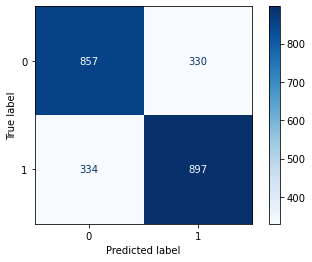

In [109]:
preds = lr2.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(yport_test, preds).ravel()
plot_confusion_matrix(lr2, Ztest, yport_test, cmap='Blues');

In [110]:
Xlem = jokes_all[['lemon','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
ylem = jokes_all['dad']

Xlem_train, Xlem_test, ylem_train, ylem_test = train_test_split(Xlem,ylem,test_size=0.2,random_state=42)

In [111]:
cv_lem = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
Xlem_train_cv = cv_lem.fit_transform(Xlem_train['lemon'])

Xlem_train_df = pd.DataFrame(Xlem_train_cv.todense(),
                              columns=cv_lem.get_feature_names()).reset_index()

Xlem_train_sent = Xlem_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()

Xlem_train_df = pd.concat([Xlem_train_df,Xlem_train_sent],axis = 1)

In [112]:
Xlem_test_cv = cv_lem.transform(Xlem_test['lemon'])
Xlem_test_df = pd.DataFrame(Xlem_test_cv.todense(),
                             columns=cv_lem.get_feature_names()).reset_index()

Xlem_test_sent = Xlem_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()

Xlem_test_df = pd.concat([Xlem_test_df,Xlem_test_sent],axis = 1)
print(Xlem_train_df.shape,Xlem_test_df.shape)

(9669, 15324) (2418, 15324)


In [113]:
Xlem_train_df.drop(columns='index',inplace=True)
Xlem_test_df.drop(columns='index',inplace=True)

In [114]:
ss = StandardScaler(with_mean=False)

Ztrain = ss.fit_transform(Xlem_train_df,ylem_train)
Ztest = ss.transform(Xlem_test_df)
print(Ztrain.shape,Ztest.shape)
lr = LogisticRegressionCV(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-5,0,41), cv = 5)
lr.fit(Ztrain,ylem_train)

(9669, 15322) (2418, 15322)


LogisticRegressionCV(Cs=array([1.00000000e-05, 1.33352143e-05, 1.77827941e-05, 2.37137371e-05,
       3.16227766e-05, 4.21696503e-05, 5.62341325e-05, 7.49894209e-05,
       1.00000000e-04, 1.33352143e-04, 1.77827941e-04, 2.37137371e-04,
       3.16227766e-04, 4.21696503e-04, 5.62341325e-04, 7.49894209e-04,
       1.00000000e-03, 1.33352143e-03, 1.77827941e-03, 2.37137371e-03,
       3.16227766e-03, 4.21...1325e-03, 7.49894209e-03,
       1.00000000e-02, 1.33352143e-02, 1.77827941e-02, 2.37137371e-02,
       3.16227766e-02, 4.21696503e-02, 5.62341325e-02, 7.49894209e-02,
       1.00000000e-01, 1.33352143e-01, 1.77827941e-01, 2.37137371e-01,
       3.16227766e-01, 4.21696503e-01, 5.62341325e-01, 7.49894209e-01,
       1.00000000e+00]),
                     cv=5, max_iter=100000, penalty='l1', random_state=42,
                     solver='liblinear')

In [115]:
lr.score(Ztrain, ylem_train), lr.score(Ztest, ylem_test),lr.C_

(0.9465301478953356, 0.7138130686517783, array([0.03162278]))

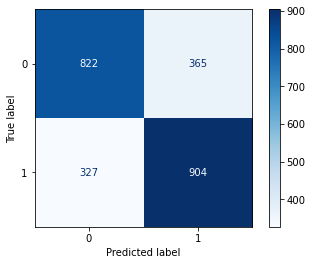

In [116]:
preds = lr.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(ylem_test, preds).ravel()
plot_confusion_matrix(lr, Ztest, ylem_test, cmap='Blues');


In [117]:
fit_list = []
for i,j in zip(Xlem_train_df.columns,lr.coef_[0]):
    if j != 0:
        fit_list.append([i,j])
sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
len(sorted_fit),sorted_fit[::-1]


(3793,
 [['and', -0.3202013459172766],
  ['knock knock', -0.19322082590819473],
  ['fucking', -0.17718380661101268],
  ['black', -0.16716568770579465],
  ['man', -0.14816211558511683],
  ['not', -0.1412386039832227],
  ['my', 0.1371070750005613],
  ['fuck', -0.1315106180590642],
  ['ft_length', -0.1306720364494283],
  ['wa', 0.12208617132488163],
  ['sent_neu', 0.10996069281431033],
  ['please', -0.1097205432558206],
  ['into bar', -0.10634586368312289],
  ['said', 0.10544108348667842],
  ['so fat', -0.10345828598088452],
  ['priest', -0.10050065613144668],
  ['sent_neg', -0.09876619381439412],
  ['blonde', -0.0981316522615204],
  ['https', -0.09682081930756727],
  ['trump', -0.09302029439106993],
  ['the chicken cross', -0.09093417248413502],
  ['this', -0.08982419552777943],
  ['gay', -0.08851740969364658],
  ['probably', -0.08675683673928275],
  ['know what', -0.08630403225053104],
  ['neither', -0.08615540368205062],
  ['limbo', 0.08476671219454845],
  ['what worse', -0.08476559619

In [118]:
lr2 = LogisticRegressionCV(random_state=42,penalty = 'l2',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-6,-2,41), cv = 5,n_jobs=1)
lr2.fit(Ztrain,ylem_train)

LogisticRegressionCV(Cs=array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
       2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
       6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
       1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
       3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
       1.00000000e-04, 1.25...58489319e-04, 1.99526231e-04,
       2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
       6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
       1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
       3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
       1.00000000e-02]),
                     cv=5, max_iter=100000, n_jobs=1, random_state=42,
                     solver='liblinear')

In [119]:
lr2.score(Ztrain, ylem_train), lr2.score(Ztest, ylem_test),lr2.C_

(0.8962664184507187, 0.7241521918941274, array([2.51188643e-05]))

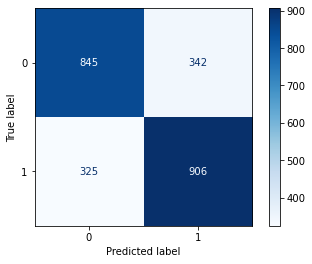

In [120]:
preds = lr2.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(ylem_test, preds).ravel()
plot_confusion_matrix(lr2, Ztest, ylem_test, cmap='Blues');

In [121]:
X = jokes_all[['full_text','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
y = jokes_all['dad']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [122]:
cv_ = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
X_train_cv = cv_.fit_transform(X_train['full_text'])

X_train_df = pd.DataFrame(X_train_cv.todense(),
                              columns=cv_.get_feature_names()).reset_index()

X_train_sent = X_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()

X_train_df = pd.concat([X_train_df,X_train_sent],axis = 1)

In [123]:
X_test_cv = cv_.transform(X_test['full_text'])
X_test_df = pd.DataFrame(X_test_cv.todense(),
                             columns=cv_.get_feature_names()).reset_index()

X_test_sent = X_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()

X_test_df = pd.concat([X_test_df,X_test_sent],axis = 1)
print(X_train_df.shape,X_test_df.shape)

(9669, 15403) (2418, 15403)


In [124]:
X_train_df.drop(columns='index',inplace=True)
X_test_df.drop(columns='index',inplace=True)

In [125]:
ss = StandardScaler(with_mean=False)

Ztrain = ss.fit_transform(X_train_df,y_train)
Ztest = ss.transform(X_test_df)
print(Ztrain.shape,Ztest.shape)
lr = LogisticRegressionCV(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-5,0,41), cv = 5)
lr.fit(Ztrain,y_train)

(9669, 15401) (2418, 15401)


LogisticRegressionCV(Cs=array([1.00000000e-05, 1.33352143e-05, 1.77827941e-05, 2.37137371e-05,
       3.16227766e-05, 4.21696503e-05, 5.62341325e-05, 7.49894209e-05,
       1.00000000e-04, 1.33352143e-04, 1.77827941e-04, 2.37137371e-04,
       3.16227766e-04, 4.21696503e-04, 5.62341325e-04, 7.49894209e-04,
       1.00000000e-03, 1.33352143e-03, 1.77827941e-03, 2.37137371e-03,
       3.16227766e-03, 4.21...1325e-03, 7.49894209e-03,
       1.00000000e-02, 1.33352143e-02, 1.77827941e-02, 2.37137371e-02,
       3.16227766e-02, 4.21696503e-02, 5.62341325e-02, 7.49894209e-02,
       1.00000000e-01, 1.33352143e-01, 1.77827941e-01, 2.37137371e-01,
       3.16227766e-01, 4.21696503e-01, 5.62341325e-01, 7.49894209e-01,
       1.00000000e+00]),
                     cv=5, max_iter=100000, penalty='l1', random_state=42,
                     solver='liblinear')

In [126]:
lr.score(Ztrain, y_train), lr.score(Ztest, y_test),lr.C_

(0.9478746509463233, 0.7100909842845327, array([0.03162278]))

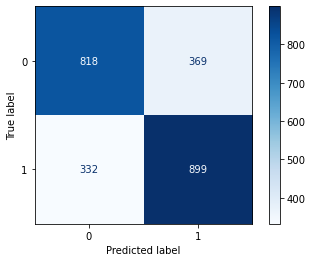

In [127]:
preds = lr.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(lr, Ztest, y_test, cmap='Blues');


In [128]:
fit_list = []
for i,j in zip(X_train_df.columns,lr.coef_[0]):
    if j != 0:
        fit_list.append([i,j])
sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
len(sorted_fit),sorted_fit[::-1]


(3804,
 [['and', -0.33108523610591295],
  ['knock knock', -0.1911340177318307],
  ['fucking', -0.1705228213034427],
  ['black', -0.15704936606842526],
  ['man', -0.15591739120862338],
  ['into bar', -0.14803178624267463],
  ['my', 0.14475708208014573],
  ['ft_length', -0.14392761929775044],
  ['not', -0.14190603407980726],
  ['was', 0.13260919125878107],
  ['fuck', -0.12662903089463837],
  ['sent_neg', -0.1173998272192149],
  ['please', -0.11476740551881137],
  ['blonde', -0.11023272903295445],
  ['said', 0.10558942123807512],
  ['sent_neu', 0.10474152469668688],
  ['priest', -0.09981999906534005],
  ['so fat', -0.09783738249991117],
  ['gay', -0.09623062542752356],
  ['talk', -0.09338391897652291],
  ['question', -0.09286136322046405],
  ['trump', -0.0919151089500024],
  ['nothing', -0.09018191251726779],
  ['what worse', -0.08882757596444599],
  ['neither', -0.08765722582872577],
  ['you could', 0.08678069312214279],
  ['but', 0.08611676315184046],
  ['this', -0.08474294929431715],
 

In [129]:
lr2 = LogisticRegressionCV(random_state=42,penalty = 'l2',max_iter = 100000,
                              solver = 'liblinear',Cs=np.logspace(-6,-2,41), cv = 5,n_jobs=1)
lr2.fit(Ztrain,y_train)

LogisticRegressionCV(Cs=array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
       2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
       6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
       1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
       3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
       1.00000000e-04, 1.25...58489319e-04, 1.99526231e-04,
       2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
       6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
       1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
       3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
       1.00000000e-02]),
                     cv=5, max_iter=100000, n_jobs=1, random_state=42,
                     solver='liblinear')

In [130]:
lr2.score(Ztrain, y_train), lr2.score(Ztest, y_test),lr2.C_

(0.888509670079636, 0.7233250620347395, array([1.99526231e-05]))

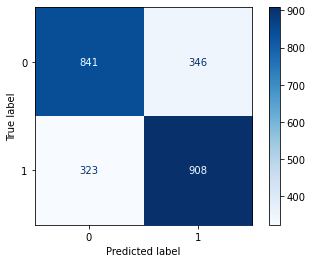

In [131]:
preds = lr2.predict(Ztest)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(lr2, Ztest, y_test, cmap='Blues');

In [132]:
fitresults = pd.read_csv('../data/fit_results.csv')

In [133]:
fitters = ['Naive Bayes\nCountV','Naive Bayes\nTf-idf','Logistic\nRegression','Decision\nTree','Random\nForest','RidgeLR','LassoLR']

In [134]:
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x = fitresults[fitresults['vector'] != 'cv']['fitter'],y=fitresults[fitresults['vector'] != 'cv']['train'],hue=fitresults[fitresults['vector'] != 'cv']['token'])
plt.title('Train Sample Accuracy', fontsize = 18, pad = 9)
plt.xlabel('Fitter', fontsize = 16, labelpad =8)
plt.xticks(fontsize=12)
plt.ylabel('Accuracy', fontsize = 16, labelpad = 8)
plt.yticks(fontsize=16);
plt.ylim(0,1.1)
ax.set_xticklabels(fitters);    

KeyError: 'vector'

<Figure size 864x576 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x = fitresults[fitresults['vector'] != 'cv']['fitter'],y=fitresults[fitresults['vector'] != 'cv']['test'],hue=fitresults[fitresults['vector'] != 'cv']['token'])
plt.title('Test Sample Accuracy', fontsize = 18, pad = 9)
plt.xlabel('Fitter', fontsize = 16, labelpad =8)
plt.xticks(fontsize=12)
plt.ylabel('Accuracy', fontsize = 16, labelpad = 8)
plt.yticks(fontsize=16);
plt.ylim(0,1.1)
ax.set_xticklabels(fitters);    

In [ ]:
gslr.best_params_

In [ ]:
tvec__